In [1]:
%cd ../..

/home/dmoreno/pipeline_v2/pipeline/training/lc_classifier_ztf/ATAT_ALeRCE


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/datasets/ZTF_ff/final/LC_MD_FEAT_241015_windows_200_12'
path_results = './results/ZTF_ff/LC_MD_FEAT/experiment_0/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
len(order_classes)

22

In [8]:
objects_partitions = pd.read_parquet('./data/datasets/ZTF_ff/partitions/241015/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF18abdrjvs',
 'aid_ZTF18abklclt',
 'aid_ZTF18admvkrs',
 'aid_ZTF18abjcwdt',
 'aid_ZTF18admqdvk',
 'aid_ZTF19aaxrrkk',
 'aid_ZTF18abuiywf',
 'aid_ZTF18abodmdn',
 'aid_ZTF18aaecona',
 'aid_ZTF18accpnyq',
 'aid_ZTF18abnzloh',
 'aid_ZTF18abcwehw',
 'aid_ZTF17aaagrko',
 'aid_ZTF19acosnzi',
 'aid_ZTF18aaxbltd',
 'aid_ZTF18aavqnnf',
 'aid_ZTF18abzpvwt',
 'aid_ZTF19aalcwjt',
 'aid_ZTF18adasioj',
 'aid_ZTF18abakjfj',
 'aid_ZTF18aaywdde',
 'aid_ZTF22aaslfam',
 'aid_ZTF18abmwuze',
 'aid_ZTF18aazngio',
 'aid_ZTF18abcoggq',
 'aid_ZTF18aatzymw',
 'aid_ZTF18abbmgxc',
 'aid_ZTF18abecxru',
 'aid_ZTF19aafncak',
 'aid_ZTF18abapgvo',
 'aid_ZTF20abmvoxo',
 'aid_ZTF18acyyhfr',
 'aid_ZTF18abaebfk',
 'aid_ZTF18abortdn',
 'aid_ZTF18abqjjjx',
 'aid_ZTF18aawgnhs',
 'aid_ZTF18aaygjmy',
 'aid_ZTF17aaawgbb',
 'aid_ZTF17aaarzyj',
 'aid_ZTF23abfysgx',
 'aid_ZTF18abfjqut',
 'aid_ZTF18abpfkxd',
 'aid_ZTF20aatuwdz',
 'aid_ZTF23aagklwb',
 'aid_ZTF21aahsgaz',
 'aid_ZTF17aabppqw',
 'aid_ZTF19aakyiem',
 'aid_ZTF19aa

In [9]:
y_real_test.shape

(8331,)

In [10]:
len(obj_label)

8331

In [11]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{14: 'AGN', 2: 'Blazar', 3: 'CEP', 11: 'CV/Nova', 1: 'DSCT', 6: 'EA', 9: 'EB/EW', 7: 'LPV', 21: 'Microlensing', 17: 'Periodic-Other', 0: 'QSO', 5: 'RRLab', 10: 'RRLc', 4: 'RSCVn', 15: 'SLSN', 16: 'SNII', 18: 'SNIIb', 19: 'SNIIn', 12: 'SNIa', 13: 'SNIbc', 20: 'TDE', 8: 'YSO'}


In [12]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['QSO', 'DSCT', 'Blazar', 'CEP', 'RSCVn', 'RRLab', 'EA', 'LPV', 'YSO', 'EB/EW', 'RRLc', 'CV/Nova', 'SNIa', 'SNIbc', 'AGN', 'SLSN', 'SNII', 'Periodic-Other', 'SNIIb', 'SNIIn', 'TDE', 'Microlensing']


In [13]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaaabj_0', b'ZTF17aaaaabj_1', b'ZTF17aaaaabj_2', ...,
        b'ZTF23aboxuyi_0', b'ZTF23abpbdyh_0', b'ZTF23abpbuha_0'],
       dtype=object),
 'y_test': tensor([10, 10, 10,  ...,  0, 11, 16]),
 'list_y_pred': {'test_16': array([10, 10, 10, ...,  0, 11, 16]),
  'test_32': array([10, 10, 10, ...,  0, 11, 16]),
  'test_64': array([10, 10, 10, ...,  0, 11, 16]),
  'test_128': array([10, 10, 10, ...,  0, 11, 16]),
  'test_256': array([10, 10, 10, ...,  0, 11, 16]),
  'test_512': array([10, 10, 10, ...,  0, 11, 16]),
  'test_1024': array([10, 10, 10, ...,  0, 11, 16]),
  'test_2048': array([10, 10, 10, ...,  0, 11, 16])},
 'list_y_pred_prob': {'test_16': array([[1.4674280e-08, 8.4437079e-06, 1.8573404e-07, ..., 2.4713489e-13,
          5.2891630e-07, 3.2515057e-11],
         [1.9532248e-08, 1.9947916e-05, 1.1978356e-07, ..., 1.9789342e-12,
          2.5769998e-07, 4.9695515e-11],
         [1.3598838e-08, 3.0103363e-05, 2.0127546e-08, ..., 6.9609290e-15,
          1.61

In [14]:
predictions['y_test'].unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21])

In [15]:
np.unique(predictions['list_y_pred']['test_2048'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [16]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print('length: ', len(idx_unique_y_test))

length:  41655
length:  41655


In [17]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaaabj', 'aid_ZTF17aaaaaej', 'aid_ZTF17aaaaafz', 'aid_ZTF17aaaaajg', 'aid_ZTF17aaaaavq', 'aid_ZTF17aaaaaya', 'aid_ZTF17aaaabbo', 'aid_ZTF17aaaabhx', 'aid_ZTF17aaaacnc', 'aid_ZTF17aaaactd', 'aid_ZTF17aaaacth', 'aid_ZTF17aaaadbq', 'aid_ZTF17aaaadmx', 'aid_ZTF17aaaaepx', 'aid_ZTF17aaaafbz', 'aid_ZTF17aaaafcd', 'aid_ZTF17aaaafdm', 'aid_ZTF17aaaagai', 'aid_ZTF17aaaaghy', 'aid_ZTF17aaaagvx', 'aid_ZTF17aaaagym', 'aid_ZTF17aaaagyq', 'aid_ZTF17aaaagyx', 'aid_ZTF17aaaahsl', 'aid_ZTF17aaaajey', 'aid_ZTF17aaaajez', 'aid_ZTF17aaaajgm', 'aid_ZTF17aaaajgo', 'aid_ZTF17aaaajhl', 'aid_ZTF17aaaajhn', 'aid_ZTF17aaaajhz', 'aid_ZTF17aaaajib', 'aid_ZTF17aaaajim', 'aid_ZTF17aaaajio', 'aid_ZTF17aaaajiy', 'aid_ZTF17aaaajji', 'aid_ZTF17aaaajka', 'aid_ZTF17aaaajor', 'aid_ZTF17aaaajow', 'aid_ZTF17aaaajoz', 'aid_ZTF17aaaajqk', 'aid_ZTF17aaaajqs', 'aid_ZTF17aaaajqz', 'aid_ZTF17aaaajra', 'aid_ZTF17aaaakgn', 'aid_ZTF17aaaakif', 'aid_ZTF17aaaakmu', 'aid_ZTF17aaaamne', 'aid_ZTF17aaaaniv', 'aid_ZTF17aaaanlg',

In [18]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([10, 10,  8, ...,  0, 11, 16]),
 'test_32': array([10, 10,  8, ...,  0, 11, 16]),
 'test_64': array([10, 10,  8, ...,  0, 11, 16]),
 'test_128': array([10, 10,  8, ...,  0, 11, 16]),
 'test_256': array([10, 10,  8, ...,  0, 11, 16]),
 'test_512': array([10, 10,  8, ...,  0, 11, 16]),
 'test_1024': array([10, 10,  8, ...,  0, 11, 16]),
 'test_2048': array([10, 10,  8, ...,  0, 11, 16])}

In [19]:
predictions['list_y_pred_avg']['test_2048'].shape

(41655,)

In [20]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg'])

In [21]:
predictions['y_test'].shape

torch.Size([291556])

In [22]:
predictions['SNID'].shape

(291556,)

In [23]:
print(idx_unique_y_test)

[0, 7, 20, 35, 49, 69, 90, 98, 113, 117, 121, 126, 134, 147, 153, 174, 187, 215, 234, 243, 257, 270, 277, 284, 299, 323, 347, 360, 381, 408, 438, 450, 480, 503, 526, 539, 552, 574, 598, 611, 632, 653, 666, 687, 708, 723, 731, 746, 762, 768, 772, 787, 796, 803, 810, 825, 837, 852, 865, 880, 896, 903, 918, 944, 948, 952, 956, 964, 983, 1001, 1007, 1035, 1048, 1062, 1069, 1089, 1097, 1112, 1127, 1142, 1147, 1155, 1166, 1181, 1196, 1203, 1206, 1212, 1215, 1216, 1222, 1226, 1228, 1242, 1249, 1262, 1269, 1284, 1299, 1306, 1315, 1322, 1337, 1351, 1355, 1358, 1370, 1372, 1379, 1383, 1387, 1389, 1401, 1407, 1411, 1415, 1419, 1422, 1432, 1439, 1443, 1457, 1471, 1484, 1492, 1499, 1510, 1520, 1531, 1542, 1561, 1566, 1572, 1578, 1584, 1589, 1593, 1599, 1604, 1610, 1615, 1621, 1626, 1645, 1664, 1675, 1684, 1693, 1701, 1708, 1718, 1732, 1741, 1748, 1755, 1774, 1793, 1803, 1821, 1831, 1852, 1868, 1877, 1887, 1905, 1922, 1940, 1950, 1965, 1972, 1981, 1990, 1999, 2008, 2026, 2043, 2051, 2070, 2084, 2098

In [24]:
print(ids_unique_real)

['aid_ZTF17aaaaabj', 'aid_ZTF17aaaaaej', 'aid_ZTF17aaaaafz', 'aid_ZTF17aaaaajg', 'aid_ZTF17aaaaavq', 'aid_ZTF17aaaaaya', 'aid_ZTF17aaaabbo', 'aid_ZTF17aaaabhx', 'aid_ZTF17aaaacnc', 'aid_ZTF17aaaactd', 'aid_ZTF17aaaacth', 'aid_ZTF17aaaadbq', 'aid_ZTF17aaaadmx', 'aid_ZTF17aaaaepx', 'aid_ZTF17aaaafbz', 'aid_ZTF17aaaafcd', 'aid_ZTF17aaaafdm', 'aid_ZTF17aaaagai', 'aid_ZTF17aaaaghy', 'aid_ZTF17aaaagvx', 'aid_ZTF17aaaagym', 'aid_ZTF17aaaagyq', 'aid_ZTF17aaaagyx', 'aid_ZTF17aaaahsl', 'aid_ZTF17aaaajey', 'aid_ZTF17aaaajez', 'aid_ZTF17aaaajgm', 'aid_ZTF17aaaajgo', 'aid_ZTF17aaaajhl', 'aid_ZTF17aaaajhn', 'aid_ZTF17aaaajhz', 'aid_ZTF17aaaajib', 'aid_ZTF17aaaajim', 'aid_ZTF17aaaajio', 'aid_ZTF17aaaajiy', 'aid_ZTF17aaaajji', 'aid_ZTF17aaaajka', 'aid_ZTF17aaaajor', 'aid_ZTF17aaaajow', 'aid_ZTF17aaaajoz', 'aid_ZTF17aaaajqk', 'aid_ZTF17aaaajqs', 'aid_ZTF17aaaajqz', 'aid_ZTF17aaaajra', 'aid_ZTF17aaaakgn', 'aid_ZTF17aaaakif', 'aid_ZTF17aaaakmu', 'aid_ZTF17aaaamne', 'aid_ZTF17aaaaniv', 'aid_ZTF17aaaanlg',

In [25]:
predictions['labels_final'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_final'] = np.array(ids_unique_real)
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41655])


,QSO,DSCT,Blazar,CEP,RSCVn,RRLab,EA,LPV,YSO,EB/EW,...,SNIbc,AGN,SLSN,SNII,Periodic-Other,SNIIb,SNIIn,TDE,Microlensing,shorten
aid_ZTF17aaaaabj,4.888849e-08,3.024921e-05,3.128384e-07,2.649032e-01,1.631199e-05,4.409233e-02,3.201558e-03,4.706371e-08,2.655164e-05,5.149852e-02,...,3.363018e-12,2.047547e-07,1.385851e-11,1.390539e-08,3.857085e-09,1.421347e-11,5.325726e-12,6.428140e-07,2.980103e-10,16
aid_ZTF17aaaaaej,8.116398e-08,5.796601e-04,4.357662e-08,4.407827e-03,6.499043e-04,1.157440e-03,1.441186e-02,2.131449e-09,2.164890e-06,4.196894e-01,...,1.026443e-11,1.227830e-07,2.262057e-11,2.403929e-07,7.265368e-08,8.235705e-11,3.080636e-09,8.528611e-08,2.096860e-09,16
aid_ZTF17aaaaafz,2.968741e-06,2.436245e-06,8.815429e-03,7.170737e-04,1.333299e-06,1.792429e-05,6.590326e-05,5.773646e-02,9.203365e-01,3.568805e-06,...,6.572670e-08,1.157654e-04,1.699684e-07,1.480876e-08,6.501745e-08,7.620816e-14,2.536032e-13,1.811603e-10,7.638184e-08,16
aid_ZTF17aaaaajg,5.081177e-06,3.944434e-05,5.979682e-07,2.370993e-02,4.074667e-03,5.851367e-01,3.254478e-04,7.155517e-07,3.089648e-07,3.801307e-03,...,1.612345e-12,6.399663e-08,3.239979e-09,2.522492e-07,5.867796e-02,1.411474e-10,1.525247e-14,3.572054e-07,2.154042e-11,16
aid_ZTF17aaaaavq,2.187035e-16,3.125270e-09,3.924790e-12,1.623996e-05,2.961242e-09,5.197440e-08,4.942703e-08,9.981793e-01,1.789452e-03,1.028844e-07,...,1.444641e-05,1.434895e-08,1.000191e-15,5.460454e-09,9.015923e-09,4.783194e-17,4.515970e-19,1.162353e-15,3.428383e-12,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23abobwsd,1.284907e-08,1.413888e-08,9.104043e-12,4.398788e-07,8.864107e-08,7.122210e-08,1.686860e-08,1.773389e-08,2.267873e-10,6.040231e-08,...,9.128563e-02,7.985989e-10,1.899702e-14,8.237643e-01,4.094371e-10,5.543679e-06,1.316918e-09,4.054834e-15,8.966564e-18,2048
aid_ZTF23abofpay,3.947310e-12,2.164278e-14,6.075783e-12,7.315250e-11,5.726089e-11,5.492615e-12,2.233996e-12,1.199887e-11,5.177468e-13,1.380738e-11,...,9.990157e-01,2.604877e-11,6.694346e-12,3.360405e-05,4.549724e-13,5.120598e-12,7.096018e-10,2.991237e-16,9.458315e-15,2048
aid_ZTF23aboxuyi,9.194975e-01,1.980925e-08,5.511493e-02,2.376985e-07,5.094325e-04,1.671364e-05,9.640426e-06,3.813661e-06,1.378949e-06,9.672429e-06,...,1.491294e-11,2.433869e-02,1.171553e-08,4.961512e-07,1.645067e-04,1.448133e-18,3.061002e-09,4.159353e-10,7.631759e-13,2048
aid_ZTF23abpbdyh,6.257974e-07,2.070920e-07,7.836654e-09,1.428220e-05,1.453729e-07,3.487483e-06,1.469030e-05,2.385857e-07,1.041046e-07,1.129212e-05,...,5.796161e-08,3.722393e-08,1.105302e-11,4.966056e-05,4.862726e-09,2.020585e-09,2.930733e-07,4.566433e-10,3.294547e-14,2048


In [26]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,QSO,DSCT,Blazar,CEP,RSCVn,RRLab,EA,LPV,YSO,EB/EW,...,SNIa,SNIbc,AGN,SLSN,SNII,Periodic-Other,SNIIb,SNIIn,TDE,Microlensing
aid_ZTF18abdrjvs,5.100414e-01,6.484780e-11,8.165561e-03,9.794341e-08,3.400924e-06,1.378760e-07,1.094444e-08,1.384437e-07,3.233236e-08,1.859115e-08,...,9.463105e-08,9.732695e-12,4.817863e-01,1.836443e-10,8.712193e-07,5.620537e-09,5.480415e-19,1.364988e-15,2.918086e-12,7.819623e-16
aid_ZTF18abklclt,2.265428e-08,9.991000e-01,3.831406e-13,5.286283e-06,2.918795e-07,1.581157e-05,2.903339e-08,2.412073e-12,7.160724e-09,1.206173e-06,...,2.222339e-09,1.377114e-09,5.418973e-10,1.038554e-15,3.184214e-09,5.077770e-10,3.579901e-13,2.573428e-10,5.092470e-16,1.213519e-15
aid_ZTF18admvkrs,5.373633e-04,3.274355e-09,9.929625e-01,1.520022e-07,7.702829e-09,8.738830e-10,1.941212e-09,2.100294e-07,1.818547e-07,1.122198e-11,...,1.284587e-08,5.291445e-15,6.494314e-03,5.053770e-13,1.407380e-06,1.483008e-11,8.325356e-17,5.308935e-12,1.346636e-15,1.291048e-12
aid_ZTF18abjcwdt,1.157036e-09,7.410601e-09,3.687323e-09,9.981204e-01,1.572890e-03,3.014644e-04,1.521767e-07,3.651400e-08,2.519306e-06,5.154067e-07,...,4.466214e-08,3.764630e-18,2.445251e-08,2.619167e-19,6.134486e-14,1.230943e-06,2.937142e-16,2.206556e-17,1.718792e-11,2.815549e-15
aid_ZTF18admqdvk,1.019623e-08,1.226191e-04,3.365597e-07,3.205521e-03,9.904833e-01,1.736697e-07,9.162481e-05,5.168694e-06,3.816945e-07,3.707050e-05,...,8.876211e-09,2.942686e-10,1.744494e-07,3.786990e-10,1.616047e-09,6.031575e-03,9.437824e-15,1.869417e-08,4.972730e-11,2.943198e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18abupzvu,7.976494e-11,2.520002e-05,3.578075e-06,1.165149e-04,2.118616e-09,4.562306e-04,5.402520e-02,1.407458e-04,9.398421e-01,3.720833e-03,...,4.431195e-11,1.006502e-14,2.100438e-07,6.462868e-14,4.549585e-11,5.319073e-14,1.000668e-16,3.756300e-15,1.331080e-09,2.158809e-12
aid_ZTF19abcebrq,2.507981e-08,1.641998e-02,1.008969e-07,1.863468e-02,1.564332e-02,1.006787e-04,1.055686e-02,3.934189e-09,2.170684e-07,8.939413e-01,...,1.241356e-09,9.972932e-13,2.627723e-07,1.347568e-10,1.784849e-08,5.291194e-03,6.530939e-10,1.938778e-08,3.766808e-08,2.679695e-09
aid_ZTF18abupzep,1.658010e-07,2.717357e-03,5.926077e-06,9.932313e-03,1.818020e-01,9.333628e-03,1.794785e-02,1.613335e-06,4.308281e-05,6.297340e-01,...,2.366444e-07,3.056792e-15,2.025977e-06,5.521354e-09,7.169069e-07,1.601432e-02,4.163066e-05,2.652409e-10,5.383229e-06,7.007954e-10
aid_ZTF18aaaokus,1.823806e-07,1.877701e-04,2.053115e-04,1.125551e-04,2.374717e-05,4.501530e-06,1.269887e-02,2.009841e-03,5.078517e-04,2.294139e-04,...,1.799333e-03,2.061979e-06,9.099523e-01,5.286567e-11,8.470354e-05,1.721056e-05,2.685000e-09,2.213000e-09,7.211923e-02,5.377834e-13


In [27]:
atat_pred_2048_time_test

,QSO,DSCT,Blazar,CEP,RSCVn,RRLab,EA,LPV,YSO,EB/EW,...,SNIa,SNIbc,AGN,SLSN,SNII,Periodic-Other,SNIIb,SNIIn,TDE,Microlensing
aid_ZTF18abdrjvs,5.100414e-01,6.484780e-11,8.165561e-03,9.794341e-08,3.400924e-06,1.378760e-07,1.094444e-08,1.384437e-07,3.233236e-08,1.859115e-08,...,9.463105e-08,9.732695e-12,4.817863e-01,1.836443e-10,8.712193e-07,5.620537e-09,5.480415e-19,1.364988e-15,2.918086e-12,7.819623e-16
aid_ZTF18abklclt,2.265428e-08,9.991000e-01,3.831406e-13,5.286283e-06,2.918795e-07,1.581157e-05,2.903339e-08,2.412073e-12,7.160724e-09,1.206173e-06,...,2.222339e-09,1.377114e-09,5.418973e-10,1.038554e-15,3.184214e-09,5.077770e-10,3.579901e-13,2.573428e-10,5.092470e-16,1.213519e-15
aid_ZTF18admvkrs,5.373633e-04,3.274355e-09,9.929625e-01,1.520022e-07,7.702829e-09,8.738830e-10,1.941212e-09,2.100294e-07,1.818547e-07,1.122198e-11,...,1.284587e-08,5.291445e-15,6.494314e-03,5.053770e-13,1.407380e-06,1.483008e-11,8.325356e-17,5.308935e-12,1.346636e-15,1.291048e-12
aid_ZTF18abjcwdt,1.157036e-09,7.410601e-09,3.687323e-09,9.981204e-01,1.572890e-03,3.014644e-04,1.521767e-07,3.651400e-08,2.519306e-06,5.154067e-07,...,4.466214e-08,3.764630e-18,2.445251e-08,2.619167e-19,6.134486e-14,1.230943e-06,2.937142e-16,2.206556e-17,1.718792e-11,2.815549e-15
aid_ZTF18admqdvk,1.019623e-08,1.226191e-04,3.365597e-07,3.205521e-03,9.904833e-01,1.736697e-07,9.162481e-05,5.168694e-06,3.816945e-07,3.707050e-05,...,8.876211e-09,2.942686e-10,1.744494e-07,3.786990e-10,1.616047e-09,6.031575e-03,9.437824e-15,1.869417e-08,4.972730e-11,2.943198e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18abupzvu,7.976494e-11,2.520002e-05,3.578075e-06,1.165149e-04,2.118616e-09,4.562306e-04,5.402520e-02,1.407458e-04,9.398421e-01,3.720833e-03,...,4.431195e-11,1.006502e-14,2.100438e-07,6.462868e-14,4.549585e-11,5.319073e-14,1.000668e-16,3.756300e-15,1.331080e-09,2.158809e-12
aid_ZTF19abcebrq,2.507981e-08,1.641998e-02,1.008969e-07,1.863468e-02,1.564332e-02,1.006787e-04,1.055686e-02,3.934189e-09,2.170684e-07,8.939413e-01,...,1.241356e-09,9.972932e-13,2.627723e-07,1.347568e-10,1.784849e-08,5.291194e-03,6.530939e-10,1.938778e-08,3.766808e-08,2.679695e-09
aid_ZTF18abupzep,1.658010e-07,2.717357e-03,5.926077e-06,9.932313e-03,1.818020e-01,9.333628e-03,1.794785e-02,1.613335e-06,4.308281e-05,6.297340e-01,...,2.366444e-07,3.056792e-15,2.025977e-06,5.521354e-09,7.169069e-07,1.601432e-02,4.163066e-05,2.652409e-10,5.383229e-06,7.007954e-10
aid_ZTF18aaaokus,1.823806e-07,1.877701e-04,2.053115e-04,1.125551e-04,2.374717e-05,4.501530e-06,1.269887e-02,2.009841e-03,5.078517e-04,2.294139e-04,...,1.799333e-03,2.061979e-06,9.099523e-01,5.286567e-11,8.470354e-05,1.721056e-05,2.685000e-09,2.213000e-09,7.211923e-02,5.377834e-13


In [28]:
atat_pred_2048_time_test.isnull().sum()

QSO               0
DSCT              0
Blazar            0
CEP               0
RSCVn             0
RRLab             0
EA                0
LPV               0
YSO               0
EB/EW             0
RRLc              0
CV/Nova           0
SNIa              0
SNIbc             0
AGN               0
SLSN              0
SNII              0
Periodic-Other    0
SNIIb             0
SNIIn             0
TDE               0
Microlensing      0
dtype: int64

In [32]:
#nan_rows = atat_pred_2048_time_test[atat_pred_2048_time_test.isna().any(axis=1)]
#nan_indices = nan_rows.index
#print(nan_indices)

In [33]:
#position = obj_label.index(nan_indices[0])
#position

In [34]:
y_pred_test = atat_pred_2048_time_test.dropna().idxmax(axis=1).values
#y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['QSO', 'DSCT', 'Blazar', ..., 'EB/EW', 'AGN', 'DSCT'], dtype=object)

In [36]:
#y_real_test = np.delete(y_real_test, position)
#y_real_test

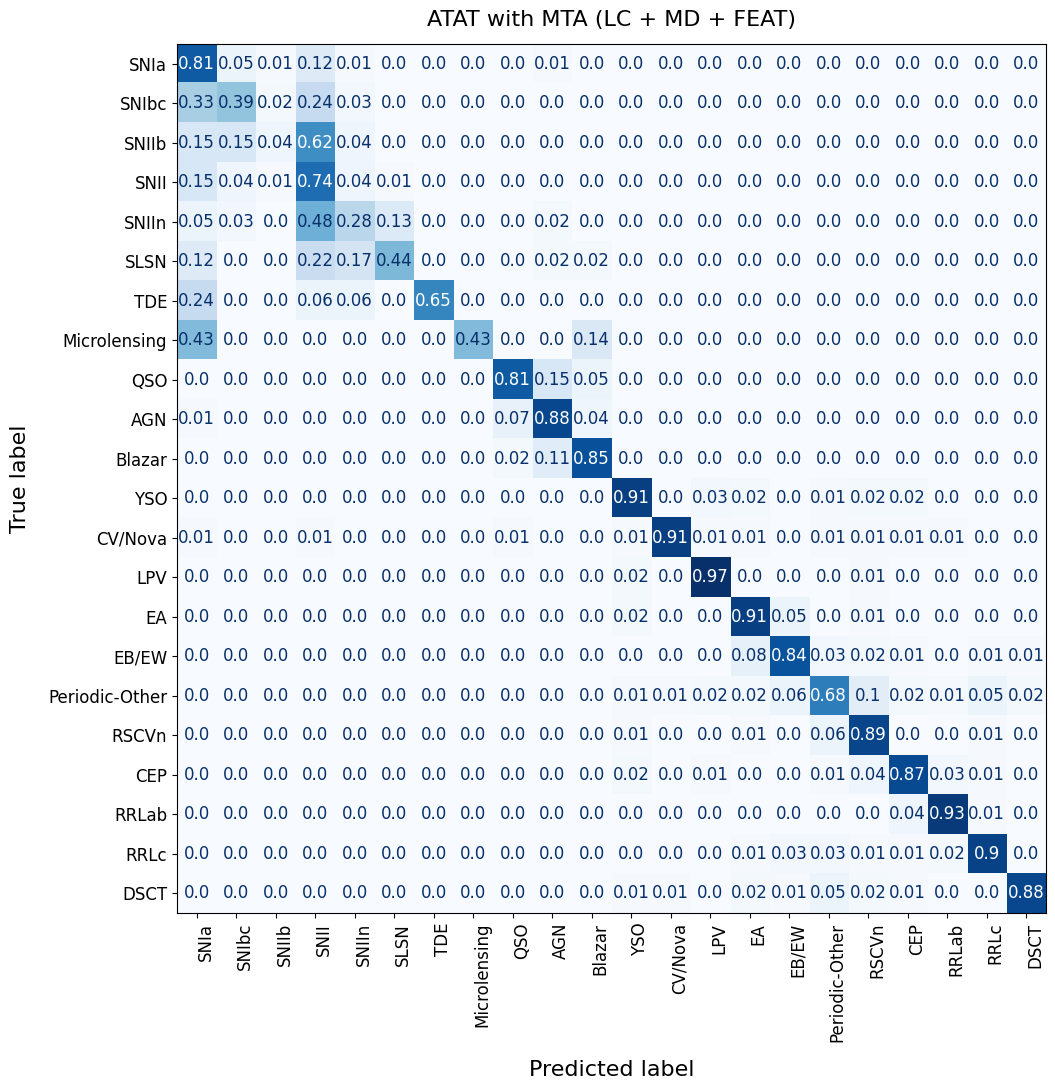

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT with MTA (LC + MD + FEAT)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.7437727794533635

In [39]:
from scipy.stats import entropy

Text(0.5, 0, 'entropy')

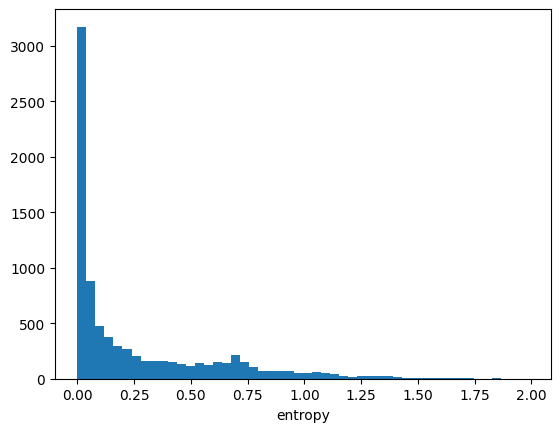

In [40]:
plt.hist(entropy(atat_pred_2048_time_test, axis=1), bins=50);
plt.xlabel('entropy')

Text(0.5, 0, 'highest prob')

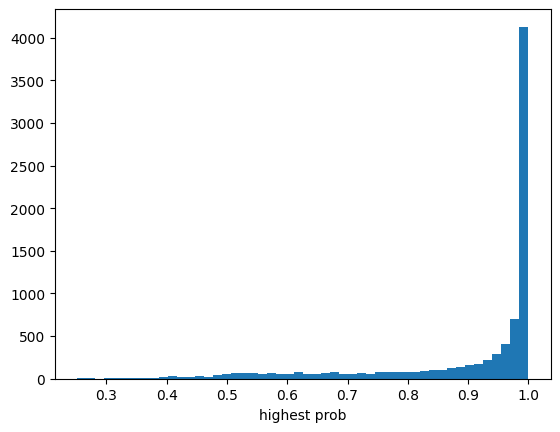

In [41]:
plt.hist(atat_pred_2048_time_test.max(axis=1), bins=50);
plt.xlabel('highest prob')